In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/semester3/Advanced_RL")
from pathlib import Path
import random

import numpy as np
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm

from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
import dataset
from dataset import *
import model
from model import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Часть первая: перенос стиля при помощи pix2pix
В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:

Датасет можно скачать здесь (и во многих других местах, должно быть ~29 мегабайт).
В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно Isola et al., 2016):   
https://arxiv.org/pdf/1611.07004.pdf


## Скачивам датасеты

In [ ]:
#!curl  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz --output facades.tar.gz
#os.makedirs('data', exist_ok=True)


In [ ]:
#!unzip -q ./facades.tar.gz  

## Датасет

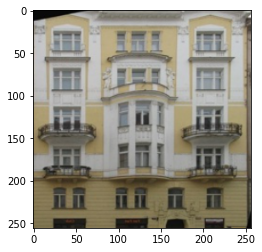

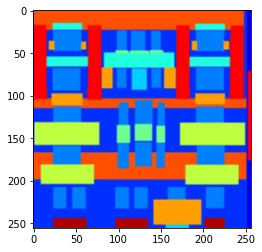

In [ ]:
dataset = Dataset(datapath='./facades/train', split = 'train')
(image, mask) = dataset.__getitem__(20)
im = transforms.ToPILImage()(image).convert("RGB")
plt.imshow(im)
plt.show()

im = transforms.ToPILImage()(mask).convert("RGB")
plt.imshow(im)
plt.show()

In [ ]:
Gen = Generator()
Discr = Discriminator()
Gen.train()
Discr.train()
x = torch.ones((2, 3, 256, 256))
mask = torch.ones((2, 3, 256, 256))
print(Gen(mask).shape)
print(Discr(x, mask).shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 30, 30])


In [ ]:
batch_size = 16
train_dataset = Dataset('./facades/train', split  = 'train')
test_dataset = Dataset('./facades/val', split = 'val')
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

lr, beta1, beta2, l1_lambda = 0.0002, 0.5, 0.999, 100
optimizer_G = torch.optim.Adam(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(Discr.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
Gen.to(device)
Discr.to(device)
print(device)

cuda


In [ ]:
lr, beta1, beta2, l1_lambda = 0.000002, 0.5, 0.999, 100

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    time.sleep(0.5)
    d_losses = []
    g_losses = []
    Gen.train()
    Discr.train()
    for batch in tqdm(train_dataloader):
        images, masks = batch
        #print(images.shape)
        images = images.to(device)
        masks = masks.to(device)
        
        #valid = Variable(torch.Tensor(images.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        #fake = Variable(torch.Tensor(images.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        

        # Generator loss
        optimizer_G.zero_grad()
        generated = Gen(masks)
        disc_generated = Discr(generated, masks)
        valid = Variable(torch.ones((images.size(0), 1, 30, 30)), requires_grad=False).to(device)
        fake = Variable(torch.zeros((images.size(0), 1, 30, 30)), requires_grad=False).to(device)
        
        g_loss = F.binary_cross_entropy(disc_generated, valid) + l1_lambda * F.l1_loss(generated, images)
        g_loss.backward()
        optimizer_G.step()

        # Dicriminator loss
        optimizer_D.zero_grad()
        # Функции потерь на настоящих и фейковых картинках
        real_loss = F.binary_cross_entropy(Discr(images, masks), valid)
        fake_loss = F.binary_cross_entropy(Discr(generated.detach(), masks), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'g_loss: {np.mean(g_losses)} d_loss: {np.mean(d_losses)}')
    if (epoch + 1) % 10 == 0:
        Gen.eval()
        plot_images(images, masks, generated.detach())

In [ ]:
torch.save(Gen.state_dict(), 'G3.pth')
torch.save(Discr.state_dict(), 'D3.pth')

In [ ]:
Gen.load_state_dict(torch.load('G3.pth'))
Discr.load_state_dict(torch.load('D3.pth'))

<All keys matched successfully>

In [ ]:
test_dataset1 = Dataset('./facades/test', split = 'test')
test_dataloader1 = data.DataLoader(test_dataset1, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(test_dataloader1)
Gen.eval()


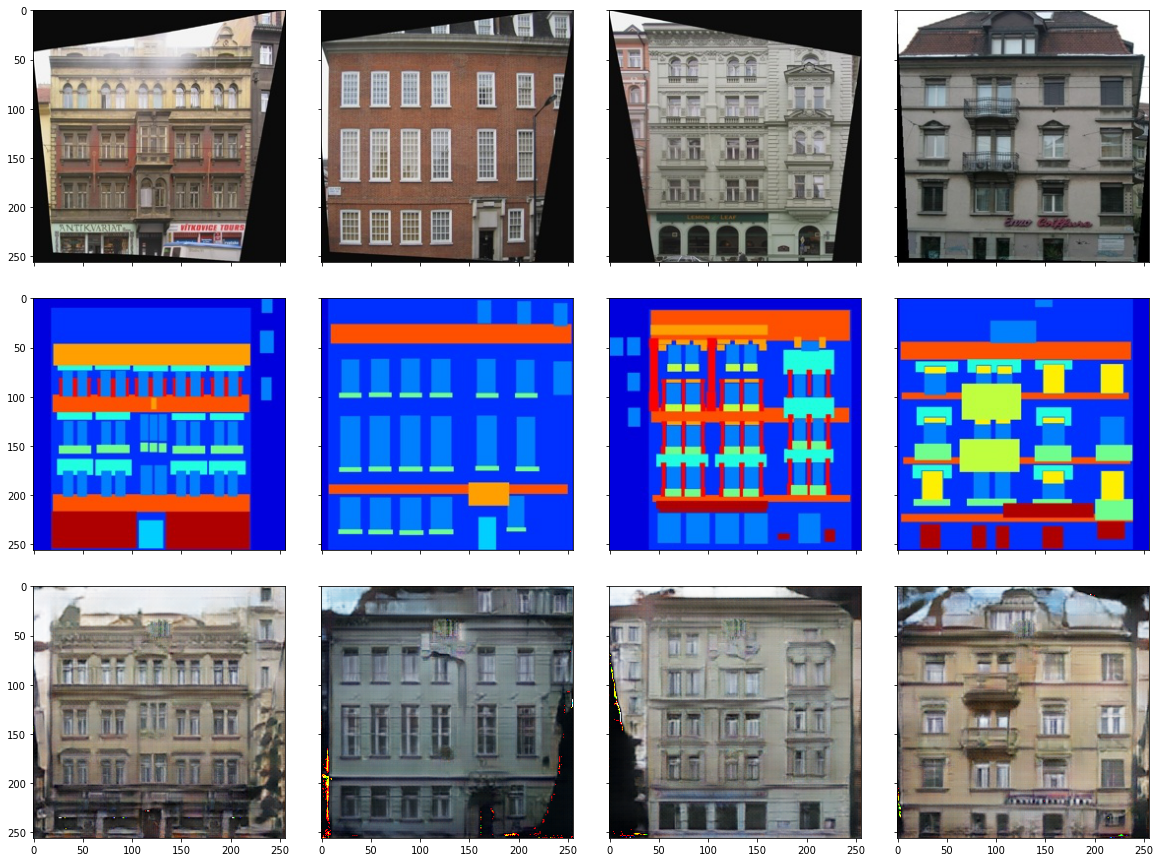

In [ ]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = netG(masks)

plot_images(images, masks, generated)

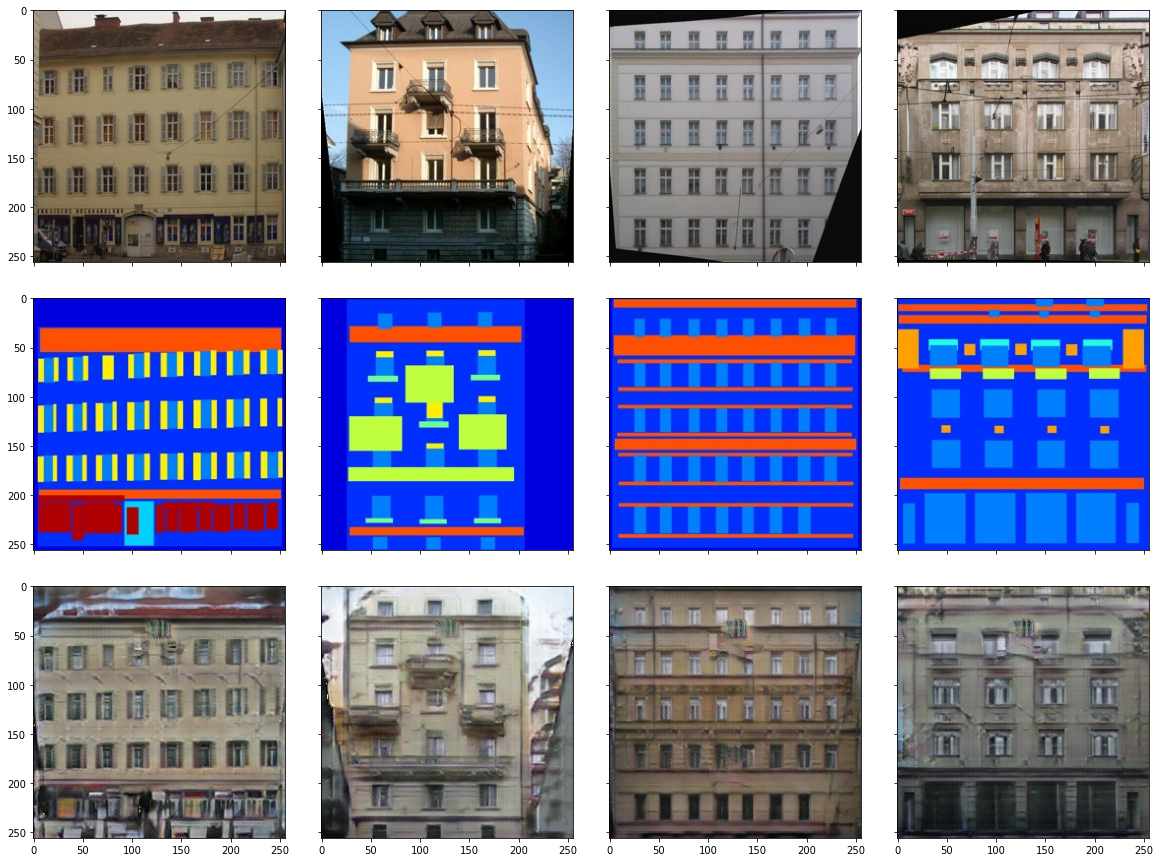

In [ ]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = netG(masks)

plot_images(images, masks, generated)

#**Часть вторая: добавим циклы**   
Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно Zhu et al., 2017):

Безусловный дискриминатор, аналогичный прошлой части и такой же генератор, на основе UNET

In [ ]:
class UnconditionalDiscriminator(nn.Module):
    def __init__(self, mean=0.0, std=0.02):
        super(UnconditionalDiscriminator, self).__init__()
        self.dlist = nn.ModuleList()
        d_input = [3, 64, 128]
        d_output = d_input[1:] + [256]
        for i in range(len(d_input)):
            self.dlist.append(Down_module(d_input[i], d_output[i], batch_norm=(i != 0), mean=mean, std=std))
        self.conv1 = nn.Conv2d(256, 512, kernel_size=(4, 4), padding=1)
        self.conv2 = nn.Conv2d(512, 1, kernel_size=(4, 4), padding=1)
        init_layer(self.conv1, mean, std, True)
        init_layer(self.conv2, mean, std, True)
        self.bn = nn.BatchNorm2d(512)

    def forward(self, x):
        #x = torch.cat([x, masks], 1)
        for block in self.dlist:
            x = block(x)
        # print(x.shape)

        x = self.conv1(x)
        x = self.bn(x)
        x = F.leaky_relu(x, 0.3)
        x = self.conv2(x)

        return torch.sigmoid(x)

In [ ]:
GXY = Generator()
DX = UnconditionalDiscriminator()
GYX = Generator()
DY = UnconditionalDiscriminator()
GXY.train()
DX.train()
GYX.train()
DY.train()
x = torch.ones((2, 3, 256, 256))
mask = torch.ones((2, 3, 256, 256))
print(GX(mask).shape)
print(DX(x).shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 30, 30])


In [ ]:
batch_size = 1
train_dataset = Dataset('./facades/train', split  = 'train')
test_dataset = Dataset('./facades/val', split = 'val')
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

l1_lambda  = 10

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
GXY.to(device)
DX.to(device)
DY.to(device)
GYX.to(device)
print(device)

cuda


In [ ]:
GXY.train()
DX.train()
GYX.train()
DY.train()

lr, beta1, beta2, l1_lambda = 0.0002, 0.5, 0.999, 100
optimizer_G = torch.optim.Adam(list(GXY.parameters()) + list(GYX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_DX  = torch.optim.Adam(DX.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_DY = torch.optim.Adam(DY.parameters(), lr=lr, betas=(beta1, beta2))

Лосс состоит из Cycle consistensy части (результата комбинации преобразований (X->Y) + (Y->X)   и (Y->X) + (X->Y))
и из Adversarial Loss



In [ ]:
num_epochs = 300

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    time.sleep(0.5)
    d_losses = []
    g_losses = []
    gxy_losses = []
    dy_losses  = []
    dx_losses  = []
    gy_losses  = []

    gx_losses = []
    gmask_losses  = []
    gimage_losses = []
    for batch in tqdm(train_dataloader):
        image, mask = batch
        #print(images.shape)
        image = image.to(device)
        mask = mask.to(device)
        
        

        # Generator loss
        optimizer_G.zero_grad()
        optimizer_DX.zero_grad()
        optimizer_DY.zero_grad()

        valid = Variable(torch.ones((image.size(0), 1, 30, 30)), requires_grad=False).to(device)
        fake = Variable(torch.zeros((image.size(0), 1, 30, 30)), requires_grad=False).to(device)


        generated_image = GXY(mask) #x->Y
        DY_generated = DY(generated_image) #Y
        cycle_mask = GYX(generated_image)
        
        generated_mask = GYX(image) #Y->X
        DX_generated = DX(generated_mask) #X
        cycle_image = GXY(generated_mask)
        

        gy_loss = torch.pow(DY_generated - valid, 2).mean() 
        gx_loss = torch.pow(DX_generated - valid, 2).mean() 
        gmask_loss = l1_lambda * F.l1_loss(cycle_mask, mask) 
        gimage_loss = l1_lambda *  F.l1_loss(cycle_image, image)

        gxy_loss = gy_loss + gx_loss + gmask_loss + gimage_loss
        gxy_loss.backward()
        optimizer_G.step()
        
     
        real_loss_Y = torch.pow(DY(image) - valid, 2).mean()
        fake_loss_Y = torch.pow(DY(generated_image.detach()), 2).mean() 
        dy_loss = (real_loss_Y + fake_loss_Y) / 2


        real_loss_X = torch.pow(DX(mask) - valid, 2).mean()
        fake_loss_X = torch.pow(DX(generated_mask.detach()), 2).mean() 
        dx_loss = (real_loss_X + fake_loss_X) / 2
        d_loss = dx_loss + dy_loss

        dy_loss.backward()
        dx_loss.backward()
        optimizer_DX.step()
        optimizer_DY.step()
        
        d_losses.append(d_loss.item())
        gxy_losses.append(gxy_loss.item())

        dy_losses.append(dy_loss.item())
        dx_losses.append(dx_loss.item())
        gy_losses.append(gy_loss.item())
        gx_losses.append(gx_loss.item())
        gmask_losses.append(gmask_loss.item())
        gimage_losses.append(gimage_loss.item())
        
    print(f'd_loss: {np.mean(d_losses):0.4f} gxy_loss: {np.mean(gxy_losses):0.4f} dy_loss: {np.mean(dy_losses):0.4f} dx_loss {np.mean(dx_losses):0.4f} gy_loss: {np.mean(gy_losses):0.4f}')
    print(f'gx_loss {np.mean(gx_losses):0.4f} gmask_loss {np.mean(gmask_losses):0.4f}  gimage_loss {np.mean(gimage_losses):0.4f}')
    if (epoch + 1) % 5 == 0:
        plot_images_cycle(image, mask, generated_image.detach(), generated_mask.detach(), cycle_image.detach(), cycle_mask.detach())
  

In [ ]:
test_dataset1 = Dataset('./facades/test', split = 'test')
test_dataloader1 = data.DataLoader(test_dataset1, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(test_dataloader1)
GXY.eval()

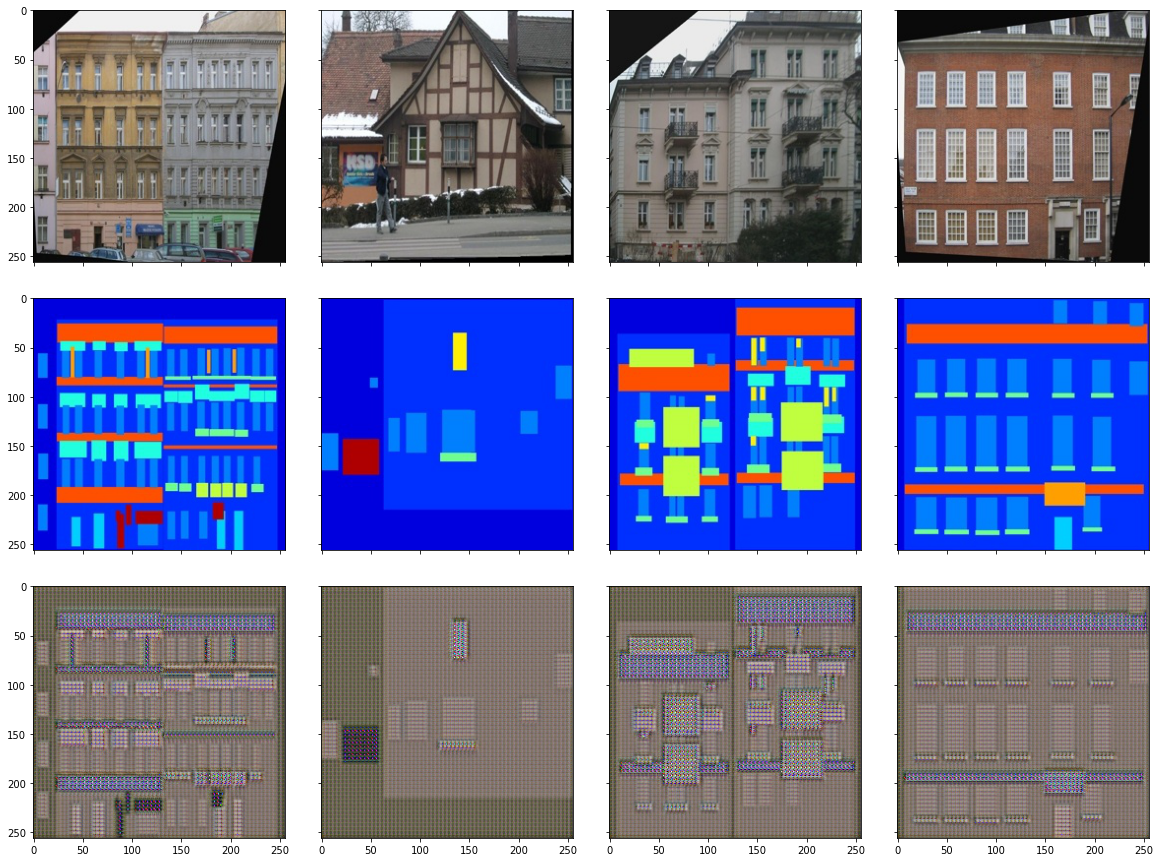

In [ ]:
batch = next(dataiter)
images, masks = batch
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    generated = GXY(masks)

plot_images(images, masks, generated)